In [3]:

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
!pip install mtcnn keras-facenet scikit-learn


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 86.3 MB/s eta 0:00:00
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10367 sha256=250b158b89bc0baa9745f1e41409a28aeffb87f8de3e714b3fbcd98ae820a45b
  Stored in directory: /root/.cache/pip/wheels/05/b0/f5/19ac49fedc10b1df3ee56b096edbcfa39d45794fccc6bcdbbf
Successfully built keras-facenet


In [5]:
import os, cv2, time, pickle, numpy as np
from IPython.display import display, clear_output, Javascript
from google.colab.patches import cv2_imshow
from base64 import b64decode

In [6]:
# ---------- Config ----------
ROOT = "/content/drive/MyDrive/Colab Notebooks/deepFaceRecognition"
DATA_DIR = os.path.join(ROOT, "data")
FACES_PKL = os.path.join(DATA_DIR, "faces.pkl")
NAMES_PKL = os.path.join(DATA_DIR, "names.pkl")
IMG_SZ = (160,160)          # FaceNet standard
N_SAVE_PER_PERSON = 30     # change if you want more/less
MIN_FACE_DET = (60,60)

os.makedirs(DATA_DIR, exist_ok=True)
print("Data folder:", DATA_DIR)

Data folder: /content/drive/MyDrive/Colab Notebooks/deepFaceRecognition/data


# **Cell:1**

In [7]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade  = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

In [8]:
import cv2

face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)


In [9]:
# ---------- Helpers ----------
def capture_frame_js(width=640, height=480):
    js = f"""
    async function capture(){{
      const video = document.createElement('video');
      const stream = await navigator.mediaDevices.getUserMedia({{video:true}});
      video.srcObject = stream;
      await new Promise(resolve => video.onloadedmetadata = resolve);
      video.play();
      const canvas = document.createElement('canvas');
      canvas.width = {width}; canvas.height = {height};
      canvas.getContext('2d').drawImage(video, 0, 0, canvas.width, canvas.height);
      stream.getTracks().forEach(track => track.stop());
      return canvas.toDataURL('image/jpeg', 0.9);
    }}
    capture();
    """
    try:
        from google.colab.output import eval_js
        data = eval_js(js)
    except Exception as e:
        print("capture_frame_js: eval_js not available.", e)
        return None
    if not data:
        return None
    header, encoded = data.split(',',1)
    img_bytes = b64decode(encoded)
    arr = np.frombuffer(img_bytes, np.uint8)
    return cv2.imdecode(arr, cv2.IMREAD_COLOR)

def is_blurry(img, thresh=60.0):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    v = cv2.Laplacian(gray, cv2.CV_64F).var()
    return v < thresh, v

def align_by_eyes(bgr_img, eye_cascade=eye_cascade):
    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3)
    if len(eyes) >= 2:
        eyes = sorted(eyes, key=lambda e: e[2], reverse=True)[:2]
        (x1,y1,w1,h1),(x2,y2,w2,h2) = eyes[0], eyes[1]
        c1 = (x1 + w1/2.0, y1 + h1/2.0); c2 = (x2 + w2/2.0, y2 + h2/2.0)
        if c1[0] > c2[0]: c1, c2 = c2, c1
        dy = c2[1]-c1[1]; dx = c2[0]-c1[0]
        angle = np.degrees(np.arctan2(dy, dx))
        h, w = bgr_img.shape[:2]
        M = cv2.getRotationMatrix2D((w/2,h/2), angle, 1.0)
        aligned = cv2.warpAffine(bgr_img, M, (w,h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        return aligned
    return bgr_img

def portrait_crop_from_bbox(frame, bbox, IMG_SZ=IMG_SZ, canvas_size=400, margin=0.6):
    x,y,w,h = bbox
    x1 = int(max(0, x - w*margin)); y1 = int(max(0, y - h*margin))
    x2 = int(min(frame.shape[1], x + w*(1+margin))); y2 = int(min(frame.shape[0], y + h*(1+margin)))
    expanded = frame[y1:y2, x1:x2].copy()
    if expanded.size == 0:
        return None
    expanded = align_by_eyes(expanded)
    canvas = np.ones((canvas_size, canvas_size, 3), dtype=np.uint8) * 255
    h_exp, w_exp = expanded.shape[:2]
    scale = min(canvas_size / max(w_exp,1), canvas_size / max(h_exp,1))
    new_w = max(1, int(w_exp * scale)); new_h = max(1, int(h_exp * scale))
    resized_portrait = cv2.resize(expanded, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
    x_off = (canvas_size - new_w) // 2; y_off = (canvas_size - new_h) // 2
    canvas[y_off:y_off+new_h, x_off:x_off+new_w] = resized_portrait
    final = cv2.resize(canvas, IMG_SZ, interpolation=cv2.INTER_CUBIC)
    return final



In [ ]:
# ---------- Load or init pickles ----------
faces_all = np.zeros((0, IMG_SZ[0]*IMG_SZ[1]*3), dtype=np.uint8)
names_all = []
if os.path.exists(FACES_PKL) and os.path.exists(NAMES_PKL):
    try:
        faces_all = pickle.load(open(FACES_PKL,'rb'))
        names_all = pickle.load(open(NAMES_PKL,'rb'))
    except:
        faces_all = np.zeros((0, IMG_SZ[0]*IMG_SZ[1]*3), dtype=np.uint8)
        names_all = []

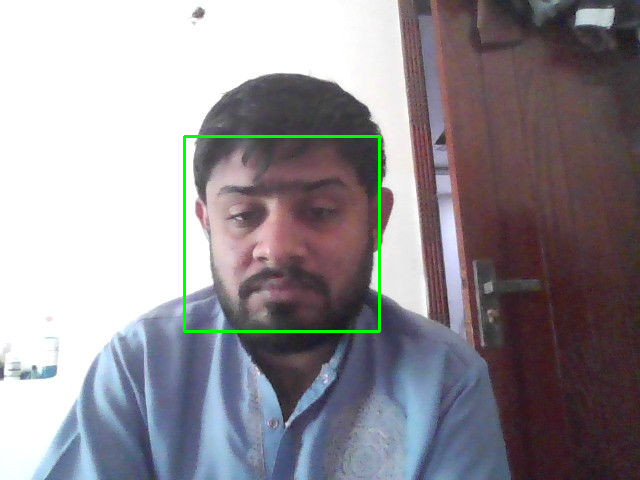

Saved 30/30 -> /content/drive/MyDrive/Colab Notebooks/deepFaceRecognition/data/Irfan/Irfan_030.jpg
Session finished. Saved: 30 images for Irfan


In [ ]:
print("\nREADY: The auto-capture helper will collect portrait images (hold still when prompted).")
name = input("Enter the person's name EXACT (e.g., Salman): ").strip()
if not name:
    raise RuntimeError("Empty name provided.")
person_dir = os.path.join(DATA_DIR, name)
os.makedirs(person_dir, exist_ok=True)

saved = 0
try:
    print(f"Starting capture for '{name}' -> target {N_SAVE_PER_PERSON} images.")
    while saved < N_SAVE_PER_PERSON:
        frame = capture_frame_js()
        if frame is None:
            print("No camera frame (allow camera permission) -- retrying...")
            time.sleep(0.6)
            continue

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=MIN_FACE_DET)
        disp = frame.copy()
        for (x,y,w,h) in faces:
            cv2.rectangle(disp,(x,y),(x+w,y+h),(0,255,0),2)
        clear_output(wait=True)
        cv2_imshow(disp)

        if len(faces) == 0:
            print("No face detected—move into camera view.")
            time.sleep(0.6)
            continue

        bbox = sorted(faces, key=lambda r: r[2]*r[3], reverse=True)[0]
        portrait = portrait_crop_from_bbox(frame, bbox)
        if portrait is None:
            print("Failed portrait crop; retrying...")
            time.sleep(0.3)
            continue

        blurry, var = is_blurry(portrait, thresh=60.0)
        if blurry:
            print(f"Rejected (blurry var={var:.1f}). Hold still.")
            time.sleep(0.4)
            continue

        # LAB equalize + slight sharpening
        lab = cv2.cvtColor(portrait, cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(lab); l = cv2.equalizeHist(l)
        lab = cv2.merge((l,a,b)); portrait_eq = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
        portrait_eq = cv2.filter2D(portrait_eq, -1, kernel)

        faces_all = np.vstack([faces_all, portrait_eq.flatten().astype(np.uint8)])
        names_all.append(name)
        saved += 1
        fn = os.path.join(person_dir, f"{name}_{saved:03d}.jpg")
        cv2.imwrite(fn, portrait_eq)
        print(f"Saved {saved}/{N_SAVE_PER_PERSON} -> {fn}")
        time.sleep(0.25)

except KeyboardInterrupt:
    print("Interrupted by user.")
finally:
    pickle.dump(names_all, open(NAMES_PKL,'wb'))
    pickle.dump(faces_all, open(FACES_PKL,'wb'))
    print("Session finished. Saved:", saved, "images for", name)

# **Build embeddings DB using keras-facenet**

In [ ]:
# === Cell 2: Build embeddings DB using keras-facenet ===
!pip install -q keras-facenet

import os, cv2, pickle, numpy as np
from keras_facenet import FaceNet

ROOT = "/content/drive/MyDrive/Colab Notebooks/deepFaceRecognition"
DATA_DIR = os.path.join(ROOT, "data")
EMB_OUT = os.path.join(DATA_DIR, "embeddings_facenet.pkl")
IMG_SZ = (160,160)

embedder = FaceNet()   # downloads model automatically
print("Loaded FaceNet embedder.")

means = {}
raw = {}

for name in sorted(os.listdir(DATA_DIR)):
    person_dir = os.path.join(DATA_DIR, name)
    if not os.path.isdir(person_dir):
        continue
    if name.lower() in ("attendance","faces.pkl","names.pkl","embeddings_facenet.pkl"):
        continue
    imgs = []
    for fn in sorted(os.listdir(person_dir)):
        if fn.lower().endswith(('.jpg','.jpeg','.png')):
            p = os.path.join(person_dir, fn)
            img = cv2.imread(p)
            if img is None:
                continue
            imgs.append(img)
    if len(imgs) == 0:
        print(f"Skipping {name}: no images found.")
        continue

    embs = []
    for img in imgs:
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        emb = embedder.embeddings([rgb])[0]
        emb = emb / (np.linalg.norm(emb) + 1e-10)
        embs.append(emb)
    raw[name] = np.vstack(embs)
    means[name] = np.mean(raw[name], axis=0)
    means[name] = means[name] / (np.linalg.norm(means[name]) + 1e-10)
    print(f"Built {raw[name].shape[0]} embeddings for {name}")

pickle.dump({'raw': raw, 'mean': means}, open(EMB_OUT, 'wb'))
print("Saved embeddings DB to:", EMB_OUT)
print("Persons:", list(means.keys()))


Loaded FaceNet embedder.
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
from keras_facenet import FaceNet

embedder = FaceNet()   # This automatically downloads facenet_keras.h5
print("Model downloaded and loaded.")


Model downloaded and loaded.


In [ ]:
open("facenet_keras.h5", "w")


<_io.TextIOWrapper name='facenet_keras.h5' mode='w' encoding='utf-8'>

In [ ]:
import os

# make sure ROOT exists
SAVE_DIR = os.path.join(ROOT, "model")
os.makedirs(SAVE_DIR, exist_ok=True)

# full file path (THIS IS IMPORTANT)
SAVE_PATH = os.path.join(SAVE_DIR, "facenet_keras.h5")

embedder.model.save(SAVE_PATH)

print("Model saved at:", SAVE_PATH)
print("Exists:", os.path.exists(SAVE_PATH))


Model saved at: /content/drive/MyDrive/Colab Notebooks/deepFaceRecognition/model/facenet_keras.h5
Exists: True


# **Recognition loop (multi-frame consensus + attendance)**

array([[[147, 149, 148],
        [147, 149, 148],
        [148, 149, 151],
        ...,
        [137, 136, 144],
        [138, 137, 145],
        [136, 135, 141]],

       [[147, 149, 148],
        [148, 150, 149],
        [149, 150, 152],
        ...,
        [136, 135, 143],
        [138, 137, 143],
        [137, 136, 141]],

       [[147, 149, 148],
        [148, 150, 149],
        [148, 150, 149],
        ...,
        [134, 133, 139],
        [135, 134, 139],
        [137, 137, 139]],

       ...,

       [[ 93,  73,  75],
        [ 93,  75,  75],
        [ 93,  75,  73],
        ...,
        [ 59,  61,  73],
        [ 54,  53,  67],
        [ 55,  54,  68]],

       [[ 86,  63,  69],
        [ 88,  68,  70],
        [ 92,  73,  75],
        ...,
        [ 54,  56,  69],
        [ 47,  46,  60],
        [ 49,  48,  62]],

       [[ 91,  68,  74],
        [ 94,  73,  78],
        [ 97,  77,  79],
        ...,
        [ 54,  56,  69],
        [ 48,  47,  61],
        [ 53,  52,  66]]], dtype=uint8)
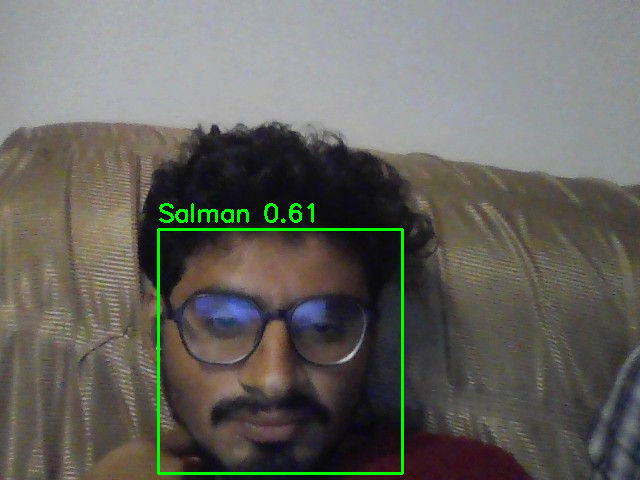

Attendance recorded for Salman (reason=consensus, sim=0.627) -> /content/drive/MyDrive/Colab Notebooks/deepFaceRecognition/data/Attendance/Attendance_13-12-2025.csv
Done.


In [ ]:
# === Cell 3 (final): robust acceptance (instant + consensus) ===
import os, cv2, pickle, numpy as np
from base64 import b64decode
from datetime import datetime, timedelta
from IPython.display import display, clear_output
from time import sleep
from google.colab.output import eval_js

ROOT = "/content/drive/MyDrive/Colab Notebooks/deepFaceRecognition"
DATA_DIR = os.path.join(ROOT, "data")
EMB_PKL = os.path.join(DATA_DIR, "embeddings_facenet.pkl")
ATT_DIR = os.path.join(DATA_DIR, "Attendance")
os.makedirs(ATT_DIR, exist_ok=True)

# ----- Tunable parameters -----
IMG_SZ = (160,160)
MIN_FACE_SIZE = (60,60)

# make capture longer and sample faster so more frames are seen
RUN_SECONDS = 12           # total capture window (increase to get more frames)
CAPTURE_INTERVAL = 0.18    # seconds between frames (smaller => more frames)

# consensus vs instant acceptance
PER_FRAME_SIM = 0.60       # frame counts when sim >= this count towards consensus
CONSENSUS_FRAMES = 2       # number of frames required to confirm (set to 1 for quick tests)
INSTANT_SIM_THRESH = 0.82  # immediate accept if any frame has sim >= this

MIN_FACE_AREA_RATIO = 0.02
UNKNOWN_FRAMES_TO_BLOCK = 2

# ----- load embedder + DB -----
from keras_facenet import FaceNet
embedder = FaceNet()

if not os.path.exists(EMB_PKL):
    raise RuntimeError("Embeddings DB not found; run Cell 2 first.")
db = pickle.load(open(EMB_PKL,'rb'))
means = db.get('mean', {})
if len(means) == 0:
    raise RuntimeError("No identities in embeddings DB. Rebuild embeddings first.")
print("Loaded identities:", list(means.keys()))

# ----- detector helper -----
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def capture_frame_once_js():
    js = """
    async function capture(){
      const video=document.createElement('video');
      const stream=await navigator.mediaDevices.getUserMedia({video:true});
      video.srcObject=stream;
      await new Promise(resolve=>video.onloadedmetadata=resolve);
      video.play();
      const canvas=document.createElement('canvas');
      canvas.width=640; canvas.height=480;
      canvas.getContext('2d').drawImage(video,0,0,canvas.width,canvas.height);
      stream.getTracks().forEach(t=>t.stop());
      return canvas.toDataURL('image/jpeg',0.9);
    }
    capture();
    """
    try:
        data = eval_js(js)
    except Exception as e:
        print("capture error:", e); return None
    if not data:
        return None
    header, encoded = data.split(",",1)
    arr = np.frombuffer(b64decode(encoded), np.uint8)
    return cv2.imdecode(arr, cv2.IMREAD_COLOR)

# ----- run loop -----
end_time = datetime.now() + timedelta(seconds=RUN_SECONDS)
frame_area = None
frame_idx = 0
unknown_frame_count = 0

per_name_counts = {}   # how many frames a name was seen (sim >= PER_FRAME_SIM)
per_name_sums = {}     # sum of sims (for averaging)
max_sim_seen = 0.0
max_sim_name = None
last_annotated = None
accepted_name = None
accept_reason = None

print("Starting recognition: RUN_SECONDS=", RUN_SECONDS,
      "CAPTURE_INTERVAL=", CAPTURE_INTERVAL,
      "CONSENSUS_FRAMES=", CONSENSUS_FRAMES,
      "INSTANT_SIM_THRESH=", INSTANT_SIM_THRESH)

while datetime.now() < end_time:
    frame = capture_frame_once_js()
    if frame is None:
        print("No frame captured; retrying...")
        sleep(CAPTURE_INTERVAL)
        continue

    if frame_area is None:
        h_frame, w_frame = frame.shape[:2]
        frame_area = h_frame * w_frame

    frame_idx += 1
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=MIN_FACE_SIZE)
    annotated = frame.copy()
    frame_has_unknown = False
    seen_this_frame = []

    if len(faces) == 0:
        clear_output(wait=True)
        display(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
        sleep(CAPTURE_INTERVAL)
        continue

    for (x,y,w,h) in faces:
        if w*h < MIN_FACE_AREA_RATIO * frame_area:
            cv2.rectangle(annotated, (x,y),(x+w,y+h),(100,100,100),1)
            cv2.putText(annotated, "Tiny",(x,y-6),cv2.FONT_HERSHEY_SIMPLEX,0.5,(100,100,100),1)
            continue

        pad = 0.6
        x1 = int(max(0, x - w*pad)); y1 = int(max(0, y - h*pad))
        x2 = int(min(frame.shape[1], x + w*(1+pad))); y2 = int(min(frame.shape[0], y + h*(1+pad)))
        crop = frame[y1:y2, x1:x2].copy()
        if crop is None or crop.size == 0:
            continue

        rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        emb = embedder.embeddings([rgb])[0]
        emb = emb / (np.linalg.norm(emb) + 1e-10)

        best_name, best_sim = None, -1.0
        for name, mean_emb in means.items():
            sim = float(np.dot(emb, mean_emb))
            if sim > best_sim:
                best_sim = sim; best_name = name

        # track max sim
        if best_sim > max_sim_seen:
            max_sim_seen = best_sim; max_sim_name = best_name

        if best_sim >= PER_FRAME_SIM:
            per_name_counts[best_name] = per_name_counts.get(best_name, 0) + 1
            per_name_sums[best_name] = per_name_sums.get(best_name, 0.0) + best_sim
            seen_this_frame.append((best_name, best_sim))
            label = f"{best_name} {best_sim:.2f}"
        else:
            frame_has_unknown = True
            label = f"Unknown {best_sim:.2f}"

        cv2.rectangle(annotated, (x,y),(x+w,y+h),(0,255,0),2)
        cv2.putText(annotated, label, (x, max(12,y-8)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0),2)

    last_annotated = annotated.copy()
    clear_output(wait=True)
    display(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))

    if frame_has_unknown:
        unknown_frame_count += 1

    # debug
    print(f"Frame #{frame_idx} seen_this_frame={seen_this_frame}")
    print("per_name_counts:", per_name_counts, "unknown_frames:", unknown_frame_count, "/", UNKNOWN_FRAMES_TO_BLOCK)
    print("max_sim_seen:", max_sim_seen, "max_sim_name:", max_sim_name)

    # instant accept
    if max_sim_seen >= INSTANT_SIM_THRESH:
        accepted_name = max_sim_name
        accept_reason = "instant"
        print("Instant acceptance:", accepted_name, "sim:", max_sim_seen)
        break

    # consensus accept
    for nm, cnt in per_name_counts.items():
        if cnt >= CONSENSUS_FRAMES:
            accepted_name = nm
            accept_reason = "consensus"
            print("Consensus acceptance:", nm, "count:", cnt)
            break
    if accepted_name:
        break

    # block if many unknown frames
    if unknown_frame_count >= UNKNOWN_FRAMES_TO_BLOCK:
        accepted_name = None
        accept_reason = "blocked_unknowns"
        print("Blocked due to unknowns:", unknown_frame_count)
        break

    sleep(CAPTURE_INTERVAL)

# show last annotated image
if last_annotated is not None:
    clear_output(wait=True)
    display(cv2.cvtColor(last_annotated, cv2.COLOR_BGR2RGB))

# fallback: average sim rule
if accepted_name is None:
    avg_candidates = []
    for nm, ssum in per_name_sums.items():
        cnt = per_name_counts.get(nm, 0)
        avg = ssum / cnt if cnt>0 else 0.0
        avg_candidates.append((nm, avg, cnt))
    if avg_candidates:
        nm, avg_sim, cnt = max(avg_candidates, key=lambda t: t[1])
        print("Avg candidate:", nm, "avg_sim:", avg_sim, "count:", cnt)
        if avg_sim >= 0.72 and cnt >= 1:
            accepted_name = nm
            accept_reason = "avg_sim"
            print("Accepted by avg_sim:", nm, avg_sim)

# write attendance if accepted
if accepted_name is None:
    print("No accepted identity. Reason:", accept_reason)
    print("No attendance recorded.")
else:
    now = datetime.now(); date_str = now.strftime("%d-%m-%Y"); time_str = now.strftime("%H:%M:%S")
    csv_path = os.path.join(ATT_DIR, f"Attendance_{date_str}.csv")
    try:
        write_header = not os.path.exists(csv_path)
        with open(csv_path, "a", newline="") as f:
            import csv
            writer = csv.writer(f)
            if write_header:
                writer.writerow(["NAME","TIME","REASON","SIM"])
            # record best sim for the name if available, else max_sim_seen
            rec_sim = None
            if accepted_name in per_name_counts:
                # compute average sim for record
                rec_sim = per_name_sums.get(accepted_name, 0.0) / max(1, per_name_counts.get(accepted_name,1))
            if rec_sim is None:
                rec_sim = max_sim_seen
            writer.writerow([accepted_name, time_str, accept_reason, f"{rec_sim:.3f}"])
        print(f"Attendance recorded for {accepted_name} (reason={accept_reason}, sim={rec_sim:.3f}) -> {csv_path}")
    except Exception as e:
        print("Failed to write attendance file:", e)

print("Done.")
